In [1]:
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
import sklearn.preprocessing as sk

In [2]:
bus = 118

# 5 bus => 6 branch
# 9 bus => 9 branch
# 14 bus => 20 branch
# 24 bus => 38 branch
# 39 bus => 46 branch
# 57 bus => 80 branch
# 118 bus => 186 branch

data_x = loadtxt(('data_x_pf_%d.csv' %bus), delimiter=',')
data_y = loadtxt(('data_y_pf_%d.csv' %bus), delimiter=',')
datadc = loadtxt(('data_y_dc_%d.csv' %bus), delimiter=',')
     
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   
print(device)

cuda:0


In [3]:
# # Find the complex power flow S from P and Q
# leny , sample = data_y.shape
# branch = int(leny/2)
# data_y = np.sqrt(np.square(data_y[0:branch,:]) + np.square(data_y[branch:leny,:]))

In [4]:
print(data_y.shape)

(372, 50000)


In [5]:
#  Eliminate the Q data, only use P data
leny , sample = data_y.shape
branch = int(leny/2)
data_y = np.abs(data_y[0:branch,:])
ref_bus = np.nonzero(np.mean(data_y,1) == 0)

In [6]:
# np.set_printoptions(threshold=np.inf) 
# print(norm_train_y[0,:])

In [7]:
# # Find the 90% interval of all data for each bus
# max_data = np.max(data_y,1)
# min_data = np.min(data_y,1)
# mean_data = np.mean(data_y,1)
# std_data = np.std(data_y,1)
# upper_data = mean_data + std_data*1.645    #90% interval
# lower_data = mean_data - std_data*1.645    #90% interval
# outlier = 9        #set the number of outlier buses per sample


# # 5 bus =>  outlier
# # 9 bus => 0 outlier
# # 14 bus => 0 outlier
# # 24 bus => 1 outlier
# # 39 bus => 0 outlier
# # 57 bus => 2 outlier
# # 118 bus => 9 outlier

# # Find the outlier data and its indice, then remove them from the total data sample
# range_data = np.transpose((np.transpose(data_y) >= upper_data) + (np.transpose(data_y) <= lower_data))
# range_data = np.sum(range_data,0, keepdims = True).flatten()
# index_data = np.nonzero(range_data > outlier)          #Remove data with how many outlier bus 
# outlier_data = np.nonzero(range_data <= outlier)

# sort_y = np.delete(data_y,index_data, axis = 1)
# sort_x = np.delete(data_x,index_data, axis = 1)
# sortdc = np.delete(datadc,index_data, axis = 1)

# outlier_y = np.delete(data_y,outlier_data, axis = 1)
# outlier_x = np.delete(data_x,outlier_data, axis = 1)

# # np.set_printoptions(threshold=np.inf) # set print option to print everything
# print(sort_y.shape)
# print(outlier_y.shape)

In [8]:
# Remove any branch with less than 50 MVA power
# mean_branch = (np.mean(data_y,1) < 75)
# data_y = np.delete(data_y, mean_branch,0)

In [9]:
# Separate generate data into  training, val, test data set
sort_x = data_x
sort_y = data_y
lenx , sample = sort_x.shape
leny , sample = sort_y.shape
sample = 10000
branch = leny
num1 = int(0.8*sample)
num2 = int(0.1*sample)


# train_x = torch.Tensor(data_x[:,0:num1]).transpose(0, 1)
# val_x   = torch.Tensor(data_x[:,num1:(num1+num2)]).transpose(0, 1)
# test_x  = torch.Tensor(data_x[:,(num1+num2):sample]).transpose(0, 1)

# train_y = torch.Tensor(data_y[:,0:num1]).transpose(0, 1)
# val_y   = torch.Tensor(data_y[:,num1:(num1+num2)]).transpose(0, 1)
# test_y  = torch.Tensor(data_y[:,(num1+num2):sample]).transpose(0, 1)


In [10]:
def sort_data(data_set,num_1,num_2,size):
    lendat , sample = data_set.shape
    data = torch.Tensor(data_set[:,num_1:num_2]).transpose(0, 1)
    data = data.reshape(data.shape[0],int(lendat/size),size).to(device) 
    data = data.transpose(1,2)
    return data

In [11]:
train_x = sort_data(sort_x,0,num1,bus)
val_x   = sort_data(sort_x,num1,num1+num2,bus)
test_x  = sort_data(sort_x,num1+num2,sample,bus)
# out_x   = sort_data(outlier_x,0,outlier_x.shape[1],bus)


train_y = sort_data(sort_y,0,num1,branch)
val_y   = sort_data(sort_y,num1,num1+num2,branch)
test_y  = sort_data(sort_y,num1+num2,sample,branch)
# out_y   = sort_data(outlier_y,0,outlier_y.shape[1],branch)
testdc  = sort_data(np.abs(datadc),num1+num2,sample,branch)

In [12]:
# Reshape the data set into correct size
# train_x = train_x.reshape(train_x.shape[0],int(lenx/bus),bus).to(device)   
# train_x = train_x.transpose(1,2)
# val_x   = val_x.reshape(val_x.shape[0],int(lenx/bus),bus).to(device)   
# val_x   = val_x.transpose(1,2)
# test_x  = test_x.reshape(test_x.shape[0],int(lenx/bus),bus).to(device)   
# test_x  = test_x.transpose(1,2)


# train_y = train_y.reshape(train_y.shape[0],int(leny/branch),branch).to(device)   
# train_y = train_y.transpose(1,2)
# val_y   = val_y.reshape(val_y.shape[0],int(leny/branch),branch).to(device)   
# val_y   = val_y.transpose(1,2)
# test_y  = test_y.reshape(test_y.shape[0],int(leny/branch),branch).to(device)   
# test_y  = test_y.transpose(1,2)

In [13]:
# Normalize the data into range between -1 and 1

# def normalize(data):
#     x , y , z = data.shape
#     max_val = torch.reshape(torch.amax(torch.abs(data),1),(x,1,z))
#     max_val = torch.amax(torch.amax(torch.abs(data),1),0)
#     norm = torch.divide(data,max_val).transpose(1,2)
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm, max_val

# def norm_train(data):
#     x , y , z = data.shape
#     avg_val = torch.mean(torch.mean(data,0),0)
#     std_val = torch.std(torch.mean(data,0),0)
#     norm = torch.divide(data-avg_val,std_val).transpose(1,2)
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm, avg_val, std_val

# def norm_eval(data,avg_val, std_val):
#     x , y , z = data.shape
#     norm = torch.divide(data-avg_val,std_val).transpose(1,2)
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm

# def norm_train(data):
#     x , y , z = data.shape
#     max_val = torch.amax(torch.amax(torch.abs(data),1),0)
#     norm = torch.divide(data,max_val).transpose(1,2)
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm, max_val

# def norm_eval(data,max_val):
#     x , y , z = data.shape
#     norm = torch.divide(data,max_val).transpose(1,2)
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm

# def normalize(data):
#     x , y , z = data.shape
#     norm = data
#     for i in range(0,z,1):
#         temp = data[:,:,i].squeeze()
# #         norm[:,:,i] = torch.Tensor(sk.quantile_transform(temp.cpu(), axis=0, n_quantiles=1000, output_distribution='uniform', ignore_implicit_zeros=False, subsample=100000, random_state=100, copy=True))
#         norm[:,:,i] = torch.Tensor(sk.maxabs_scale(temp.cpu(), axis=0, copy=True))
# #         norm[:,:,i] = torch.Tensor(sk.StandardScaler(temp.cpu(), copy=True, with_mean=True, with_std=True))
    

#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)    
#     return norm


# def norm_train(data):
#     x , y , z = data.shape
#     max_val = torch.amax(torch.amax(data,1),0)
#     min_val = torch.amin(torch.amin(data,1),0)
#     norm = torch.divide((data-min_val),(max_val-min_val)).transpose(1,2)
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm, max_val, min_val

# def norm_eval(data,max_val,min_val):
#     x , y , z = data.shape
#     norm = torch.divide((data-min_val),(max_val-min_val)).transpose(1,2)
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm

In [14]:
# def norm_train_y(data):
#     x , y , z = data.shape    
#     min_val = torch.amin(torch.amin(data,1),0)
#     max_val = torch.amax(torch.amax(data,1),0)    
#     norm = torch.divide(data-min_val,max_val-min_val).transpose(1,2)
#     norm = norm*0.1 + 0.9
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm, max_val, min_val

# def norm_eval_y(data,max_val,min_val):
#     x , y , z = data.shape
#     norm = torch.divide(data-min_val,max_val-min_val).transpose(1,2)
#     norm = norm*0.1 + 0.9
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm


def norm_train(data):
    x , y , z = data.shape
    max_val = torch.amax(torch.amax(torch.abs(data),1),0)
    norm = torch.divide(data,max_val).transpose(1,2)    
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm, max_val

def norm_eval(data,max_val):
    x , y , z = data.shape
    norm = torch.divide(data,max_val).transpose(1,2) 
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm

def y_norm_train(data):
    x , y , z = data.shape    
    
    # Turn data points into z-score
    mean_val = torch.mean(torch.mean(data,1),0)
    std_val = torch.std(torch.std(data,1),0)
    data = torch.divide(data - mean_val,std_val)
    
    # Normalize data between 0.9 and 1
    min_val = torch.amin(torch.amin(data,1),0)
    max_val = torch.amax(torch.amax(data,1),0)    
    norm = torch.divide(data-min_val,max_val-min_val).transpose(1,2)
    norm = norm*0.1 + 0.9
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm, max_val, min_val, mean_val, std_val

def y_norm_eval(data,max_val,min_val,mean_val,std_val):
    x , y , z = data.shape
    
    data = torch.divide(data - mean_val,std_val)
    norm = torch.divide(data-min_val,max_val-min_val).transpose(1,2)
    norm = norm*0.1 + 0.9
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm

In [15]:
# temp = train_x[:,:,0].squeeze()
# sk.robust_scale(temp.cpu(), with_centering=True, with_scaling=True, quantile_range=[25.0, 75.0], copy=True)

In [16]:
# norm_train_x, avg_train_x, std_train_x = norm_train(train_x)
# norm_train_y, avg_train_y, std_train_y = norm_train(train_y)
# norm_val_x = norm_eval(val_x, avg_train_x, std_train_x)
# norm_val_y = norm_eval(val_y, avg_train_y, std_train_y)

# norm_train_x, max_train_x = norm_train(train_x)
# norm_train_y, max_train_y = norm_train(train_y)
# norm_val_x = norm_eval(val_x, max_train_x)
# norm_val_y = norm_eval(val_y, max_train_y)

# norm_train_x, max_train_x, min_train_x = norm_train(train_x)
# norm_train_y, max_train_y, min_train_y = norm_train(train_y)
# norm_val_x = norm_eval(val_x, max_train_x, min_train_x)
# norm_val_y = norm_eval(val_y, max_train_y, min_train_y)

# norm_train_x = normalize(train_x)
# norm_train_y = normalize(train_y)
# norm_val_x   = normalize(val_x)
# norm_val_y   = normalize(val_y)
# print(norm_train_x[1,:])


norm_train_y, max_train_y = norm_train(train_y)
norm_val_y = norm_eval(val_y, max_train_y)
norm_train_x, max_train_x = norm_train(train_x)
norm_val_x = norm_eval(val_x, max_train_x)
# norm_train_y, max_train_y, min_train_y, mean_train_y, std_train_y = y_norm_train(train_y)
# norm_val_y = y_norm_eval(val_y, max_train_y, min_train_y, mean_train_y, std_train_y)

In [17]:
# Training model

class PowerFlow(nn.Module):
    def __init__(self):
        super(PowerFlow,self).__init__()
        #layer definitions
#         self.FC1   = nn.Linear(bus*3,500)
#         self.FC2   = nn.Linear(500,100)
#         self.FC3   = nn.Linear(100,50)
#         self.FC4   = nn.Linear(50,branch)
#         self.act   = nn.LeakyReLU(0.3)


#         self.FC1   = nn.Linear(bus*3,500)
#         self.FC2   = nn.Linear(500,1000)
#         self.FC3   = nn.Linear(1000,1500)
#         self.FC4   = nn.Linear(1500,2000)
#         self.FC5   = nn.Linear(2000,1800)
#         self.FC6   = nn.Linear(1800,1600)
#         self.FC7   = nn.Linear(1600,1400)
#         self.FC8   = nn.Linear(1400,1200)
#         self.FC9   = nn.Linear(1200,1000)
#         self.FC10  = nn.Linear(1000,800)
#         self.FC11  = nn.Linear(800,600)
#         self.FC12  = nn.Linear(600,400)
#         self.FC13  = nn.Linear(400,200)
#         self.FC14  = nn.Linear(200,branch)
#         self.act1   = nn.PReLU(500,0.25)
#         self.act2   = nn.PReLU(1000,0.25)
#         self.act3   = nn.PReLU(1500,0.25)
#         self.act4   = nn.PReLU(2000,0.25)
#         self.act5   = nn.PReLU(1800,0.25)
#         self.act6   = nn.PReLU(1600,0.25)
#         self.act7   = nn.PReLU(1400,0.25)
#         self.act8   = nn.PReLU(1200,0.25)
#         self.act9   = nn.PReLU(1000,0.25)
#         self.act10  = nn.PReLU(800,0.25)
#         self.act11  = nn.PReLU(600,0.25)
#         self.act12  = nn.PReLU(400,0.25)
#         self.act13  = nn.PReLU(200,0.25)


#     def forward(self, x):
#         x = self.act1(self.FC1(x))
#         x = self.act2(self.FC2(x))
#         x = self.act3(self.FC3(x))
#         x = self.act4(self.FC4(x))
#         x = self.act5(self.FC5(x))
#         x = self.act6(self.FC6(x))
#         x = self.act7(self.FC7(x))
#         x = self.act8(self.FC8(x))
#         x = self.act9(self.FC9(x))
#         x = self.act10(self.FC10(x))
#         x = self.act11(self.FC11(x))
#         x = self.act12(self.FC12(x))
#         x = self.act13(self.FC13(x))

        
#         x = self.FC14(x)
#         return x

        self.FC1   = nn.Linear(lenx,500)
        self.FC2   = nn.Linear(500,1000)
        self.FC3   = nn.Linear(1000,800)
        self.FC4   = nn.Linear(800,600)
        self.FC5   = nn.Linear(600,400)
        self.FC6   = nn.Linear(400,200)
        self.FC7   = nn.Linear(200,branch)
        self.act1   = nn.LeakyReLU(0.3)
        self.act2   = nn.LeakyReLU(0.4)


    def forward(self, x):
        x = self.act1(self.FC1(x))
        x = self.act1(self.FC2(x))
        x = self.act1(self.FC3(x))
        x = self.act2(self.FC4(x))
        x = self.act2(self.FC5(x))
        x = self.act2(self.FC6(x))
        x = self.FC7(x)
        return x


# Loss function
def MSE(ypred,ytrue):
    loss = nn.MSELoss()
#     loss = nn.L1Loss()
    return loss(ypred,ytrue)

def abs_error(ypred,ytrue,ref):
    error = 2 * torch.abs(ypred - ytrue) / torch.abs(ypred + ytrue)
#     error = torch.abs(ypred - ytrue) / torch.abs(ytrue)              #Percent error formula
#     error[ytrue <= 0.001] = torch.abs(ypred[ytrue <= 0.001])
    mean_error = torch.mean(error)*100
    return mean_error.detach().cpu().numpy()

In [18]:
# Define training variables

CNNPF = PowerFlow().to(device)
optimizer = optim.SGD(CNNPF.parameters(), lr=0.0003, momentum=0.7)
# optimizer = optim.Adam(CNNPF.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-07, weight_decay=0.1, amsgrad=False)
hloss = []
train_err = []
val_err = []
n = 0
num_epochs  = 4500
batch = 250
iter = int(num1/batch)
disp = 15

# S power flow
# 5 bus  =>  outlier
# 9 bus  => 500 epoch
# 14 bus => 1000 epoch
# 24 bus => 1500 epoch
# 39 bus => 1500 epoch
# 57 bus => 3500 epoch
# 118 bus => 4500 epoch

# P power flow
# 5 bus  =>  outlier
# 9 bus  => 500 epoch
# 14 bus => 1000 epoch
# 24 bus => 2000 epoch
# 39 bus => 1500 epoch
# 57 bus => 3500 epoch
# 118 bus => 4500 epoch



# Start training
CNNPF = CNNPF.train()

for epoch in range(num_epochs):
    index = np.random.choice(num1, batch*iter, replace=False)
    index = np.reshape(index,[iter,batch])
    
    for i in range(iter):
        CNNPF = CNNPF.train()
        X = norm_train_x[index[i,:],:]     
        Y = norm_train_y[index[i,:],:]
        
        optimizer.zero_grad()

        # Forward + backward + optimize
        Y_pred = CNNPF(X)
        loss = MSE(Y_pred,Y)
        loss.backward()
        optimizer.step()
        n += 1
        
    if epoch % disp == 0:
    
        hloss.append(loss.detach().cpu().numpy()) 
        CNNPF = CNNPF.eval()
        pred_y = CNNPF(norm_val_x).detach()
        error = abs_error(pred_y,norm_val_y,ref_bus)
        val_err.append(error) 

        pred_y = CNNPF(norm_train_x).detach()
        error = abs_error(pred_y,norm_train_y,ref_bus)
        train_err.append(error)        

        print(loss.detach().cpu().numpy(), error) 


0.03483603 1153.508
0.03429093 1197.3966
0.03373226 892.9414
0.03321577 1109.9397
0.032726668 2731.7224
0.032195758 891.79456
0.03175218 989.9784
0.031252623 997.17865
0.030789712 2335.9167
0.030241597 1101.4202
0.029874839 2109.8845
0.029393435 976.84326
0.028867614 1263.3312
0.02850669 1023.29987
0.028063212 1097.9974
0.027627867 1357.3938
0.027130354 4193.8535
0.026759898 2232.5852
0.0263493 957.16144
0.02592803 1295.0121
0.025531536 1242.2491
0.025132459 650.473
0.024752392 723.02966
0.024365716 491.39886
0.02392944 500.68735
0.023588257 426.12476
0.023153258 431.93268
0.022752361 572.76404
0.022418825 393.23517
0.021989888 440.65222
0.021693015 477.49023
0.021250764 940.7818
0.020912344 450.4659
0.020557266 488.6115
0.020191748 605.54175
0.019844977 469.0844
0.01946469 438.17374
0.019087596 4714.135
0.018776836 3060.4846
0.018419066 512.2372
0.018083034 523.3453
0.017748566 496.50906
0.017404158 470.72693
0.01708665 521.31915
0.016756134 465.5021
0.016366474 529.6021
0.01609271 43

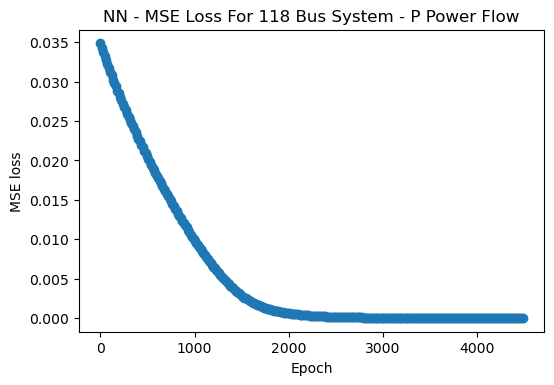

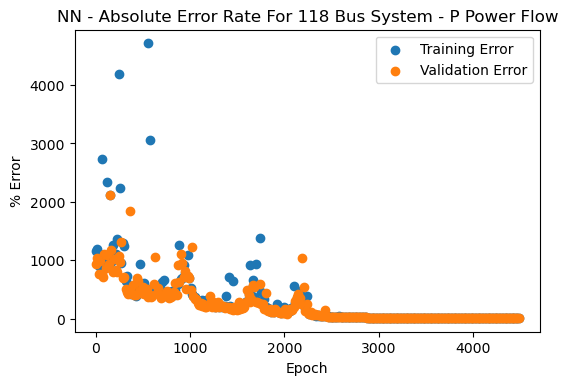

In [19]:
# Plot the result  
plt.figure(dpi=100)       
plt.scatter(range(0,num_epochs,disp),hloss)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('NN - MSE Loss For {} Bus System - P Power Flow'.format(bus))
plt.savefig("Graph_NN/NN_Loss_S_{}.png".format(bus))

plt.figure(dpi=100) 
plt.scatter(range(0,num_epochs,disp),train_err, label = "Training Error")
plt.scatter(range(0,num_epochs,disp),val_err, label = 'Validation Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("% Error")
plt.title('NN - Absolute Error Rate For {} Bus System - P Power Flow'.format(bus))
plt.savefig("Graph_NN/NN_Error_S_{}.png".format(bus))

In [20]:
# Start eval
CNNPF = CNNPF.eval()

norm_test_x = norm_eval(test_x, max_train_x)
norm_test_y = norm_eval(test_y, max_train_y)
# norm_test_y = y_norm_eval(test_y, max_train_y, min_train_y, mean_train_y, std_train_y)

pred_y = CNNPF(norm_test_x)
error = abs_error(pred_y,norm_test_y,ref_bus)
print(error)

9.602118


In [21]:
# Compare between AC and DC power flow

# dc_error = 2 * (np.abs(datadc) - np.abs(data_y)) / (np.abs(data_y)+np.abs(datadc))
# dc_error = np.mean(dc_error)*100
# print(dc_error)

# norm_testdc = y_norm_eval(testdc, max_train_y, min_train_y, mean_train_y, std_train_y)
norm_testdc = norm_eval(testdc, max_train_y)
testdc_error = abs_error(norm_testdc,norm_test_y,ref_bus)
print(testdc_error)
# error = 2 * torch.abs(ypred - ytrue) / torch.abs(ypred + ytrue)


# testdc_error = torch.abs(norm_testdc - norm_test_y) / torch.abs(norm_testdc + norm_test_y)
# testdc_error = torch.round(testdc_error,decimals=5)
# testdc_error = np.round(testdc_error.detach().cpu().numpy(), decimals=5)
np.set_printoptions(threshold=np.inf) 


# print(np.isnan((test_y + testdc).detach().cpu().numpy()))

15.524858


In [22]:
# # Compare between outlier and training data


# norm_out_x = norm_eval(out_x, max_train_x)
# norm_out_y = norm_eval(out_y, max_train_y)
# # norm_out_y = y_norm_eval(out_y, max_train_y, min_train_y, mean_train_y, std_train_y)

# pred_out_y = CNNPF(norm_out_x)
# out_error = abs_error(pred_out_y,norm_out_y,ref_bus)
# print(out_error)

In [23]:
#Print out sample for observation

Y = Y.reshape(batch,branch,1)
Y_pred = Y_pred.reshape(batch,branch,1)
print(Y[1,:].detach().cpu().numpy())
print(Y_pred[1,:].detach().cpu().numpy())

error = torch.mean(abs((Y-Y_pred)/Y),0)
print(error.detach().cpu().numpy())

[[3.05979382e-02]
 [8.84406045e-02]
 [2.22961575e-01]
 [1.55820668e-01]
 [1.92772910e-01]
 [8.24108347e-02]
 [9.60083961e-01]
 [7.47329831e-01]
 [9.68935966e-01]
 [1.44546986e-01]
 [1.72766119e-01]
 [7.58399665e-02]
 [7.57523701e-02]
 [2.44508553e-02]
 [4.16699387e-02]
 [7.46963769e-02]
 [3.51910405e-02]
 [1.34767045e-03]
 [6.23917626e-03]
 [1.18941851e-02]
 [2.29774609e-01]
 [4.22352850e-02]
 [1.75724864e-01]
 [3.87961045e-02]
 [2.54290104e-02]
 [2.00728457e-02]
 [6.71559945e-02]
 [9.57557857e-02]
 [1.17805243e-01]
 [1.45559302e-02]
 [3.51816297e-01]
 [1.90011635e-01]
 [3.08289796e-01]
 [7.36292228e-02]
 [3.79763059e-02]
 [5.05128384e-01]
 [1.49911106e-01]
 [4.92321789e-01]
 [2.75363084e-02]
 [1.77279990e-02]
 [2.03268602e-01]
 [6.72289431e-02]
 [3.15045640e-02]
 [1.21047543e-02]
 [9.09655541e-03]
 [4.99561056e-03]
 [7.28255510e-02]
 [3.47814560e-02]
 [6.57625049e-02]
 [2.07144588e-01]
 [5.32253444e-01]
 [1.19445667e-01]
 [9.68593732e-02]
 [1.28774747e-01]
 [6.15550205e-02]
 [3.699127

In [24]:
def denorm_y(norm, max_val):
#     norm = (norm - 0.9) * 10
    data = torch.multiply(norm,max_val)
#     data = data + min_val
    data = data.transpose(0,1).detach().cpu().numpy()       
    return data 

# def denorm_y(norm, max_val, min_val, mean_val, std_val):
#     norm = (norm - 0.9) * 10
#     data = torch.multiply(norm,max_val-min_val)
#     data = data + min_val
#     data = torch.multiply(data,std_val) + mean_val
#     data = data.transpose(0,1).detach().cpu().numpy()       
#     return data 

In [25]:
# pred = denorm_y(pred_y,max_train_y, min_train_y, mean_train_y, std_train_y)
# test = denorm_y(norm_test_y,max_train_y, min_train_y, mean_train_y, std_train_y)
pred = denorm_y(pred_y,max_train_y)
test = denorm_y(norm_test_y,max_train_y)
testdc1 = denorm_y(norm_testdc,max_train_y)

error = 2 * np.abs((test-pred)) / np.abs((test+pred))
norm_error = 2 * torch.abs((norm_test_y-pred_y)) / torch.abs((norm_test_y+pred_y))


print(np.mean(error)*100)
print(abs_error(pred_y,norm_test_y,ref_bus))




9.602116793394089
9.602118


In [26]:
with open(("Result/S_{}_Bus_Predict.csv".format(bus)), 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(branch):
        csv_writer.writerow(pred[i,:])
        
with open(("Result/S_{}_Bus_Test.csv".format(bus)), 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(branch):
        csv_writer.writerow(test[i,:])
        
with open(("Result/S_{}_Bus_DC.csv".format(bus)), 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(branch):
        csv_writer.writerow(testdc1[i,:])        